"""
# Minimal Object Detection with PyTorch
This notebook shows a simple object detection example using Faster R-CNN
"""


## 1. Installation and Imports



In [ ]:

# %%
# Install required packages (uncomment if needed)
# !pip install torch torchvision matplotlib pillow

# %%
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
import random
import os
from torchvision.models.detection import *


# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

## 2. Create Synthetic Data


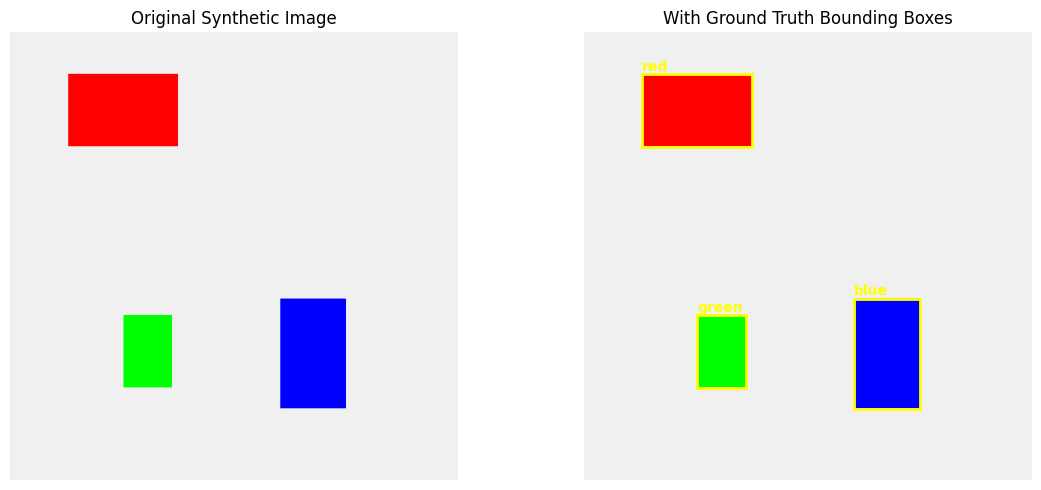

In [2]:
def create_synthetic_image():
    """Create a synthetic image with colored rectangles"""
    # Create a 600x600 image with 3 channels
    img = np.ones((600, 600, 3), dtype=np.uint8) * 240  # Light gray background
    
    # Create some colored rectangles (objects)
    objects = []
    
    # Red rectangle
    x1, y1 = random.randint(50, 200), random.randint(50, 200)
    x2, y2 = x1 + random.randint(100, 150), y1 + random.randint(80, 120)
    img[y1:y2, x1:x2] = [255, 0, 0]  # Red
    objects.append({'bbox': [x1, y1, x2, y2], 'label': 'rectangle', 'color': 'red'})
    
    # Blue rectangle
    x1, y1 = random.randint(300, 450), random.randint(300, 450)
    x2, y2 = x1 + random.randint(80, 120), y1 + random.randint(100, 150)
    img[y1:y2, x1:x2] = [0, 0, 255]  # Blue
    objects.append({'bbox': [x1, y1, x2, y2], 'label': 'rectangle', 'color': 'blue'})
    
    # Green rectangle
    x1, y1 = random.randint(100, 400), random.randint(100, 400)
    x2, y2 = x1 + random.randint(60, 100), y1 + random.randint(60, 100)
    img[y1:y2, x1:x2] = [0, 255, 0]  # Green
    objects.append({'bbox': [x1, y1, x2, y2], 'label': 'rectangle', 'color': 'green'})
    
    return img, objects

# %%
# Create and display synthetic image
img, true_objects = create_synthetic_image()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Show original image
ax[0].imshow(img)
ax[0].set_title('Original Synthetic Image')
ax[0].axis('off')

# Show image with ground truth bounding boxes
ax[1].imshow(img)
for obj in true_objects:
    x1, y1, x2, y2 = obj['bbox']
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                            linewidth=2, edgecolor='yellow', facecolor='none')
    ax[1].add_patch(rect)
    ax[1].text(x1, y1-5, obj['color'], color='yellow', fontsize=10, fontweight='bold')
ax[1].set_title('With Ground Truth Bounding Boxes')
ax[1].axis('off')

plt.tight_layout()
plt.show()


## 3. Prepare Data for PyTorch


In [3]:
# Convert to PyTorch tensor
transform = T.Compose([T.ToTensor()])
image_tensor = transform(img)

# Create ground truth in COCO format
boxes = []
labels = []

for obj in true_objects:
    x1, y1, x2, y2 = obj['bbox']
    boxes.append([x1, y1, x2, y2])
    # Use label 1 for all rectangles (in real scenario, you'd have multiple classes)
    labels.append(1)

# Convert to tensors
boxes = torch.tensor(boxes, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.int64)

# Create target dictionary
target = {
    'boxes': boxes,
    'labels': labels,
}

print(f"Image tensor shape: {image_tensor.shape}")
print(f"Number of bounding boxes: {len(boxes)}")
print(f"Labels: {labels}")

Image tensor shape: torch.Size([3, 600, 600])
Number of bounding boxes: 3
Labels: tensor([1, 1, 1])


## 4. Create and Load Pretrained Model


In [17]:
# Load pretrained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Switch to evaluation mode
model.eval()
print("Model loaded successfully!")

# %%
# Check model structure
print("Model architecture:")
print(model)


Model loaded successfully!
Model architecture:
FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBa

## 5. Make Predictions


Number of predictions: 0


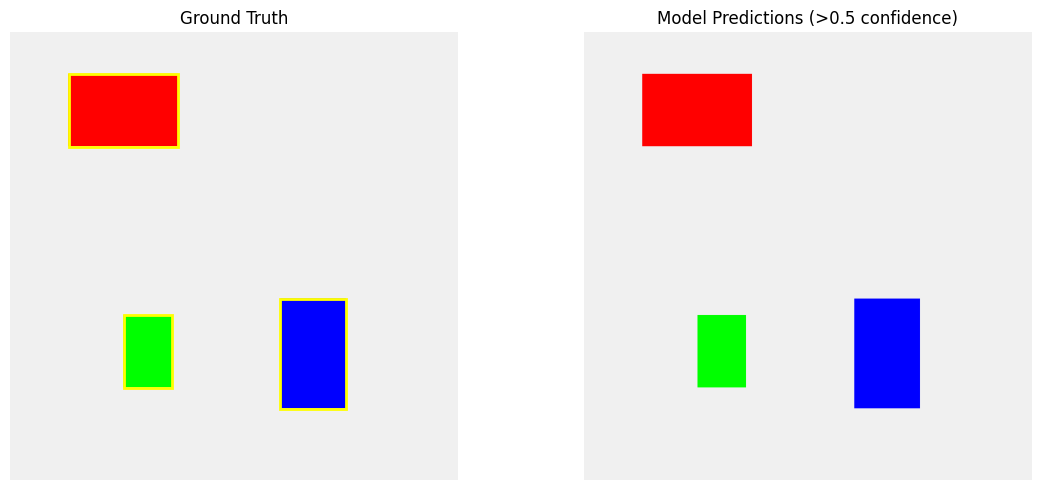

In [5]:
# Make prediction (no gradients needed for inference)
with torch.no_grad():
    predictions = model([image_tensor])

print(f"Number of predictions: {len(predictions[0]['boxes'])}")

# %%
# Display predictions
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Show ground truth
ax[0].imshow(img)
for obj in true_objects:
    x1, y1, x2, y2 = obj['bbox']
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                            linewidth=2, edgecolor='yellow', facecolor='none')
    ax[0].add_patch(rect)
ax[0].set_title('Ground Truth')
ax[0].axis('off')

# Show model predictions (with confidence threshold)
ax[1].imshow(img)
pred = predictions[0]
scores = pred['scores']

# Filter predictions by confidence threshold
confidence_threshold = 0.5
high_conf_indices = scores > confidence_threshold
high_conf_boxes = pred['boxes'][high_conf_indices]
high_conf_scores = scores[high_conf_indices]

for i, (box, score) in enumerate(zip(high_conf_boxes, high_conf_scores)):
    x1, y1, x2, y2 = box.int().tolist()
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                            linewidth=2, edgecolor='red', facecolor='none')
    ax[1].add_patch(rect)
    ax[1].text(x1, y1-5, f'{score:.2f}', color='red', fontsize=10, fontweight='bold')
    print(f"Prediction {i+1}: Box={[x1, y1, x2, y2]}, Score={score:.3f}")

ax[1].set_title('Model Predictions (>0.5 confidence)')
ax[1].axis('off')

plt.tight_layout()
plt.show()

## 6. Custom Model for Specific Classes


In [6]:
# Let's create a custom model for detecting specific shapes/colors
class CustomObjectDetector:
    def __init__(self, num_classes=2):  # Background + our object class
        # Load pretrained model
        self.model = fasterrcnn_resnet50_fpn(pretrained=True)
        
        # Get number of input features for the classifier
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        
        # Replace the pre-trained head with a new one
        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        
    def predict(self, image_tensor, confidence_threshold=0.5):
        """Make predictions on an image"""
        self.model.eval()
        with torch.no_grad():
            predictions = self.model([image_tensor])
        
        # Filter by confidence threshold
        pred = predictions[0]
        mask = pred['scores'] > confidence_threshold
        
        return {
            'boxes': pred['boxes'][mask],
            'labels': pred['labels'][mask],
            'scores': pred['scores'][mask]
        }

# Initialize custom detector
detector = CustomObjectDetector(num_classes=2)


## 7. Test on Multiple Images


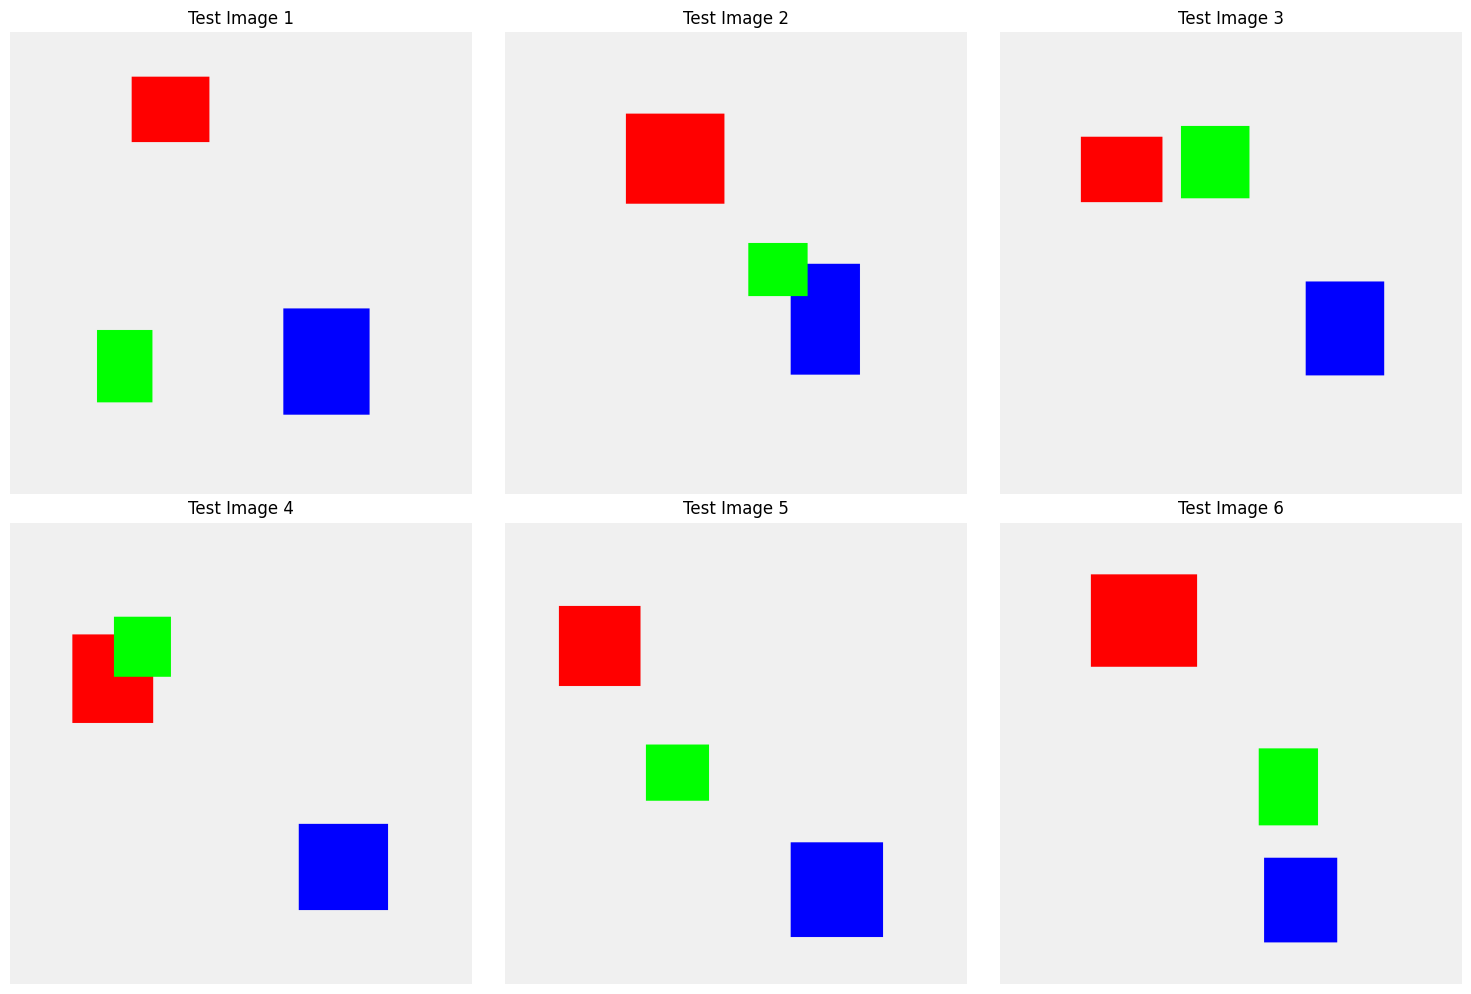

In [7]:
# Create and test on multiple synthetic images
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i in range(6):
    row, col = i // 3, i % 3
    ax = axes[row, col]
    
    # Create new synthetic image
    test_img, _ = create_synthetic_image()
    test_tensor = transform(test_img)
    
    # Get predictions
    with torch.no_grad():
        preds = model([test_tensor])
    
    # Display image with predictions
    ax.imshow(test_img)
    pred = preds[0]
    
    # Filter predictions
    confidence_threshold = 0.3
    high_conf_indices = pred['scores'] > confidence_threshold
    
    if high_conf_indices.sum() > 0:
        boxes = pred['boxes'][high_conf_indices]
        scores = pred['scores'][high_conf_indices]
        
        for box, score in zip(boxes, scores):
            x1, y1, x2, y2 = box.int().tolist()
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                   linewidth=2, edgecolor='red', facecolor='none',
                                   alpha=0.7)
            ax.add_patch(rect)
            ax.text(x1, y1-5, f'{score:.2f}', 
                   color='red', fontsize=8, fontweight='bold',
                   bbox=dict(facecolor='white', alpha=0.7))
    
    ax.set_title(f'Test Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

## 8. Performance Metrics


In [8]:
def calculate_iou(box1, box2):
    """Calculate Intersection over Union for two boxes [x1, y1, x2, y2]"""
    # Calculate intersection coordinates
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    # Calculate intersection area
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    
    # Calculate union area
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection
    
    return intersection / union if union > 0 else 0

# %%
# Calculate IoU between predictions and ground truth
print("IoU (Intersection over Union) Analysis:")
print("-" * 50)

pred_boxes = high_conf_boxes.int().tolist()
true_boxes = boxes.int().tolist()

for i, pred_box in enumerate(pred_boxes):
    for j, true_box in enumerate(true_boxes):
        iou = calculate_iou(pred_box, true_box)
        if iou > 0.1:  # Only show boxes with some overlap
            print(f"Prediction {i+1} vs Ground Truth {j+1}: IoU = {iou:.3f}")

IoU (Intersection over Union) Analysis:
--------------------------------------------------


## 9. Save and Load Model


In [9]:
# Save model weights
torch.save(model.state_dict(), 'object_detection_model.pth')
print("Model saved as 'object_detection_model.pth'")

# %%
# Example of loading the model
def load_saved_model():
    """Load a saved model"""
    # Create model architecture
    loaded_model = fasterrcnn_resnet50_fpn(pretrained=False)
    num_classes = 91  # COCO dataset has 91 classes
    
    # Load weights
    loaded_model.load_state_dict(torch.load('object_detection_model.pth'))
    loaded_model.eval()
    
    return loaded_model

print("Model can be loaded using load_saved_model() function")

Model saved as 'object_detection_model.pth'
Model can be loaded using load_saved_model() function


## 10. Quick Summary


In [ ]:
print("=" * 60)
print("OBJECT DETECTION PIPELINE SUMMARY")
print("=" * 60)
print("""
1. Data Preparation: Create/load images with bounding boxes
2. Model Selection: Choose pretrained model (Faster R-CNN, YOLO, etc.)
3. Preprocessing: Convert images to tensors, normalize
4. Inference: Pass images through model
5. Postprocessing: Filter predictions by confidence threshold
6. Visualization: Draw bounding boxes on images
7. Evaluation: Calculate metrics like IoU, mAP
""")

print(f"\nModel used: Faster R-CNN with ResNet-50-FPN backbone")
print(f"Input shape: {image_tensor.shape}")
print(f"Number of classes: 91 (COCO dataset classes)")
print(f"Number of predictions: {len(predictions[0]['boxes'])}")
print(f"High confidence predictions: {len(high_conf_boxes)}")